In [5]:
import pandas as pd

df = pd.read_csv(r'E:\humanseg\filtered_china_weibo.csv')
df

,lng,lat,user_id,location,city,place
0,131.003800,45.774051,5063955649,七台河,七台河,七台河
1,131.003800,45.774051,7287623027,七台河,七台河,七台河
2,130.560186,45.750696,5736678741,亿达广场,七台河,亿达广场
3,131.003800,45.774051,5301664430,七台河,七台河,七台河
4,131.008093,45.779053,7741689184,阿波罗西餐厅,七台河,阿波罗西餐厅
...,...,...,...,...,...,...
11093316,117.014394,25.091226,6519819059,三叔泰粉(世纪天成广场店),龙岩,三叔泰粉(世纪天成广场店)
11093317,116.367313,25.838730,3911288878,又见,龙岩,又见
11093318,117.017586,25.086141,7436441317,莲西小区,龙岩,莲西小区
11093319,116.357666,25.834032,2816328150,汀州中医院,龙岩,汀州中医院


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphSAGE
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pygeohash as geohash
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec
import pickle
import os

# 定义chunk大小
CHUNK_SIZE = 100000  # 可以根据你的内存情况调整这个值

# 定义保存路径
SAVE_PATH = './cach/'
os.makedirs(SAVE_PATH, exist_ok=True)

def save_object(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 1. 读取CSV数据并训练Word2Vec模型
def process_chunks(file_path):
    word2vec_path = os.path.join(SAVE_PATH, 'word2vec_model.pkl')
    if os.path.exists(word2vec_path):
        print("Loading existing Word2Vec model...")
        return load_object(word2vec_path)

    print("Starting to process chunks for Word2Vec model...")
    addresses = set()
    total_rows = sum(1 for _ in open(file_path)) - 1  # 减去标题行
    with tqdm(total=total_rows, desc="Reading addresses") as pbar:
        for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE):
            addresses.update(chunk['location'].unique())
            pbar.update(len(chunk))
    
    addresses = list(addresses)
    print(f"Training Word2Vec model on {len(addresses)} unique addresses...")
    word2vec_model = Word2Vec([addresses], vector_size=55, window=5, min_count=1, workers=4)
    save_object(word2vec_model, word2vec_path)
    print("Word2Vec model training completed and saved.")
    return word2vec_model

word2vec_model = process_chunks(r'E:\humanseg\filtered_china_weibo.csv')

# 定义一个函数来获取文本的Word2Vec编码
def get_word2vec_encoding(address):
    if address in word2vec_model.wv:
        return word2vec_model.wv[address]
    else:
        return np.zeros(word2vec_model.vector_size)

# 2. 创建地理哈希编码
def encode_geohash(row):
    return geohash.encode(row['lat'], row['lng'], precision=7)

# 3. 统计每个用户访问每个位置的次数并构建图
def process_data(file_path):
    graph_path = os.path.join(SAVE_PATH, 'graph.pkl')
    if os.path.exists(graph_path):
        print("Loading existing graph...")
        return load_object(graph_path)

    print("Starting to process data and build graph...")
    G = nx.Graph()
    total_rows = sum(1 for _ in open(file_path)) - 1  # 减去标题行
    
    with tqdm(total=total_rows, desc="Processing data") as pbar:
        for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE):
            chunk['geohash'] = chunk.apply(encode_geohash, axis=1)
            df_count = chunk.groupby(['user_id', 'location', 'geohash', 'lat', 'lng']).size().reset_index(name='visit_count')
            
            for _, row in df_count.iterrows():
                user = f"user_{row['user_id']}"
                location = f"loc_{row['location']}"
                
                if not G.has_node(user):
                    G.add_node(user, type='user')
                
                if not G.has_node(location):
                    G.add_node(location, type='location', geohash=row['geohash'], lat=row['lat'], lng=row['lng'], place=row['location'])
                
                if G.has_edge(user, location):
                    G[user][location]['weight'] += row['visit_count']
                else:
                    G.add_edge(user, location, weight=row['visit_count'])
            
            pbar.update(len(chunk))
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    save_object(G, graph_path)
    print("Graph saved.")
    return G

# 4. 构建图
G = process_data(r'E:\humanseg\filtered_china_weibo.csv')

# 5. 准备GCN输入
def prepare_gcn_input(G):
    data_path = os.path.join(SAVE_PATH, 'gcn_data_new.pkl')
    if os.path.exists(data_path):
        print("Loading existing GCN input data...")
        return load_object(data_path)

    print("Preparing GCN input...")
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()]).t().contiguous()
    edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float)

    # 创建初始节点特征
    print("Creating initial node features...")
    node_features = []
    for node in tqdm(G.nodes(), desc="Processing nodes"):
        if G.nodes[node]['type'] == 'user':
            node_features.append(torch.zeros(64))  # 用户节点使用零向量
        else:
            # 位置节点使用geohash的ASCII编码、经度和纬度
            geohash_feature = torch.tensor([ord(c) for c in G.nodes[node]['geohash']], dtype=torch.float)
            lat_lng_feature = torch.tensor([G.nodes[node]['lat'], G.nodes[node]['lng']], dtype=torch.float)
            place_feature = torch.tensor(get_word2vec_encoding(G.nodes[node]['place']), dtype=torch.float)
            node_features.append(torch.cat([geohash_feature, lat_lng_feature, place_feature]))

    x = torch.stack(node_features)

    # 标准化特征  ##去掉标准化
    # print("Standardizing features...")
    # scaler = StandardScaler()
    # x = torch.tensor(scaler.fit_transform(x), dtype=torch.float)

    # 创建PyTorch Geometric数据对象
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
    
    save_object((data, node_mapping), data_path)
    print("GCN input data saved.")
    
    return data, node_mapping

data, node_mapping = prepare_gcn_input(G)

print("Data processing completed.")

c:\Users\20143\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading existing Word2Vec model...
Loading existing graph...
Loading existing GCN input data...
Data processing completed.


In [3]:
data

Data(x=[3034786, 64], edge_index=[2, 7147374], edge_weight=[7147374])

In [4]:
# 6. 定义GraphSAGE模型
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.sage1 = GraphSAGE(in_channels, hidden_channels, num_layers=2)
        self.sage2 = GraphSAGE(hidden_channels, out_channels, num_layers=2)

    def forward(self, x, edge_index, edge_weight):
        x = self.sage1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.sage2(x, edge_index, edge_weight)
        return x

# 7. 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = GraphSAGEModel(64, 128, 64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in tqdm(range(100)):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.mse_loss(out, data.x)
    loss.backward()
    optimizer.step()

# 8. 获取节点嵌入
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index, data.edge_weight).cpu().numpy()

np.save(os.path.join(SAVE_PATH, 'node_embeddings_new.npy'), node_embeddings)

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm
import os

# 定义保存路径
SAVE_PATH = './cach'  # 请确保这与您保存文件时使用的路径相同

# 加载node embeddings
node_embeddings = np.load(os.path.join(SAVE_PATH, 'node_embeddings_new.npy'))

print("Node embeddings shape:", node_embeddings.shape)

# 打印前几个embedding的样本
print("\nSample embeddings:")
for i in range(5):
    print(f"Node {i}: {node_embeddings[i][:5]}...")  # 只打印前5个值

Node embeddings shape: (3034786, 64)

Sample embeddings:
Node 0: [-1.0114654  -0.08304948  1.448982    0.8261576   0.8393031 ]...
Node 1: [110.901764 103.59792   82.59708   86.90547   89.02833 ]...
Node 2: [109.89093  103.08317   82.20337   84.970566  87.22317 ]...
Node 3: [-1.0114654  -0.08304948  1.448982    0.8261576   0.8393031 ]...
Node 4: [107.75247  100.93317   80.180435  85.27018   86.42163 ]...


In [5]:
# 9. 计算location的segregation水平
location_segregation = {}

for node in tqdm(G.nodes()):
    if G.nodes[node]['type'] == 'location':
        users = [n for n in G.neighbors(node)]
        if len(users) > 1:
            user_embeddings = [node_embeddings[node_mapping[u]] for u in users]
            # distances = euclidean_distances(user_embeddings)

            similarities = cosine_similarity(user_embeddings)
            avg_similarity = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
            segregation = avg_similarity

            # avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
            # segregation = np.exp(-avg_distance)
            location_segregation[node] = {
                'geohash': G.nodes[node]['geohash'],
                'place': G.nodes[node]['place'],
                'lat': G.nodes[node]['lat'],
                'lng': G.nodes[node]['lng'],
                'segregation': segregation  # 转换为相似度
            }

# 10. 创建结果DataFrame
results_df = pd.DataFrame.from_dict(location_segregation, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'node'}, inplace=True)

results_df.to_csv('./cach/location_segregation_results.csv', index=False)
print(results_df.head())

100%|██████████| 3034786/3034786 [09:53<00:00, 5116.07it/s] 


                 node  geohash           place        lat         lng  \
0  loc_1927·鲁迅与内山纪念书局  wtw3u7f  1927·鲁迅与内山纪念书局  31.266743  121.479122   
1              loc_三亚  w7jzuh4              三亚  18.260463  109.514491   
2             loc_三门峡  wqpjf7m             三门峡  34.779318  111.200545   
3              loc_上海  wtw3sq8              上海  31.237888  121.476038   
4              loc_三明  wsetkyz              三明  26.273155  117.640610   

   segregation  
0     0.853908  
1     0.940905  
2     0.963880  
3     0.881913  
4     0.964558  


Text(0, 0.5, 't-SNE feature 2')

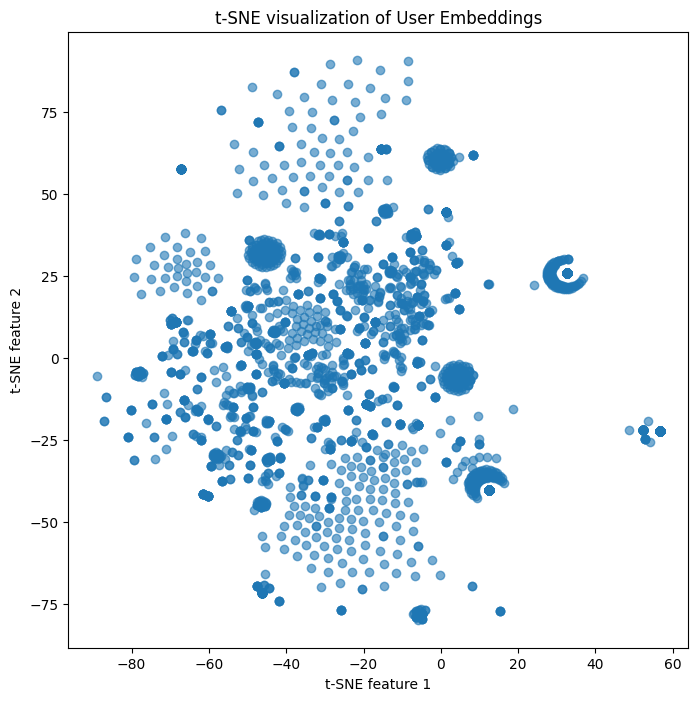

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 9. 提取用户嵌入
user_embeddings = []
user_ids = []
for node, idx in node_mapping.items():
    if node.startswith('user_'):
        user_embeddings.append(node_embeddings[idx])
        user_ids.append(node.split('_')[1])  # 提取用户ID

user_embeddings = np.array(user_embeddings)

# 10. 使用t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# 11. 绘制用户嵌入的散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], alpha=0.6)
plt.title("t-SNE visualization of User Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")